In [1]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING --progress_bar None --disable_caching orbital_plane_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s orbital_plane_Scene"

Jupyter Capture Output v0.0.11


In [2]:
# rotates a point around the x-axis / y-axis / z-axis by angle
def rotate_x(point, angle):
    x_rotated = point[0]
    y_rotated = np.cos(angle)*point[1] - np.sin(angle)*point[2]
    z_rotated = np.sin(angle)*point[1] + np.cos(angle)*point[2]
    return np.array([x_rotated, y_rotated, z_rotated])


def rotate_y(point, angle):
    x_rotated = np.cos(angle)*point[0] + np.sin(angle)*point[2]
    y_rotated = point[1]
    z_rotated = -np.sin(angle)*point[0] + np.cos(angle)*point[2]
    return np.array([x_rotated, y_rotated, z_rotated])


def rotate_z(point, angle):
    x_rotated = np.cos(angle)*point[0] - np.sin(angle)*point[1]
    y_rotated = np.sin(angle)*point[0] + np.cos(angle)*point[1]
    z_rotated = point[2]
    return np.array([x_rotated, y_rotated, z_rotated])

In [3]:
class OrbitalPlane(Mobject):
    def __init__(self, coordinate_system, periabsis, periabsis_factor, **kwargs):
        super().__init__(**kwargs)
        self.ax = coordinate_system

        # ellipsis parameters
        self.a = periabsis * periabsis_factor               # long half-axis (on y-axis)
        self.b = periabsis                                  # short half-axis (on x_axis)

        self.e = np.sqrt(self.a**2 - self.b**2)


    # returns the position on the orbital plane ellipsis given a parameter t in [0, 2*Pi]
    def get_orbit_position(self, t):
        x_ellipsis = self.a * np.cos(t) - self.e
        y_ellipsis = self.b * np.sin(t)
        z_ellipsis = 0
        # return np.array(self.ax.c2p(x_ellipsis, y_ellipsis, z_ellipsis))
        return np.array([x_ellipsis, y_ellipsis, z_ellipsis])
    
    
    def get_rotated_orbit_position(self, t, inclination, Omega, omega):
        orbit_position = self.get_orbit_position(t)
        # calculate omega (rotation around z-axis)
        orbit_position = rotate_z(orbit_position, omega)

        # calculate inclination (rotation around x-axis)
        orbit_position = rotate_y(orbit_position, inclination)

        # calculate Omega (rotation around z-axi)
        orbit_position = rotate_z(orbit_position, Omega)
        return orbit_position
    

    # returns a reference plane of same geometric shape (same rotations as orbital plane, just without inclination)
    def get_reference_plane(self, inclination, Omega, omega):
        t_array = np.linspace(0, 2*PI, 1000)
        ellipsis_list = [self.get_orbit_position(t) for t in t_array]

        # calculate rotations and add them to orbital plane array
        rotated_ellipsis_list = []
        for point in ellipsis_list:
            temp_point = point

            # calculate omega (rotation around z-axis)
            temp_point = rotate_z(temp_point, omega)

            # calculate Omega (rotation around z-axi)
            temp_point = rotate_z(temp_point, Omega)

            # add rotated point to array
            rotated_ellipsis_list.append(self.ax.c2p(*temp_point))

        reference_plane = Polygon(*rotated_ellipsis_list, color = WHITE, fill_opacity = 0.5, stroke_width = 2)
        return reference_plane


    # returns the rotated periapsis (shortest distance between star and exoplanet)
    def get_periapsis(self, inclination, Omega, omega):
        periapsis_start = np.array(self.ax.c2p(0, 0, 0))
        periapsis_end = np.array([self.a - self.e, 0, 0])

        # apply rotations to periapsis end point
        periapsis_end = rotate_z(periapsis_end, omega)
        periapsis_end = rotate_y(periapsis_end, inclination)
        periapsis_end = rotate_z(periapsis_end, Omega)

        periapsis_end = self.ax.c2p(*periapsis_end)
        periapsis = Line(start = periapsis_start, end = periapsis_end, stroke_width = 2, color = PURE_BLUE)
        return periapsis
    

    # returns orbit polygon
    def get_orbit(self, inclination, Omega, omega):
        t_array = np.linspace(0, 2*PI, 1000)
        ellipsis_list = [self.get_orbit_position(t) for t in t_array]

        # calculate rotations and add them to orbital plane array
        rotated_ellipsis_list = []
        for point in ellipsis_list:
            temp_point = point

            # calculate omega (rotation around z-axis)
            temp_point = rotate_z(temp_point, omega)

            # calculate inclination (rotation around x-axis)
            temp_point = rotate_y(temp_point, inclination)

            # calculate Omega (rotation around z-axi)
            temp_point = rotate_z(temp_point, Omega)

            # add rotated point to array
            rotated_ellipsis_list.append(self.ax.c2p(*temp_point))

        orbit = Polygon(*rotated_ellipsis_list, color = RED, stroke_opacity = 0.5, stroke_width = 4)
        return orbit


    # places the orbital plane given the three rotations
    def get_orbital_plane(self, inclination, Omega, omega):
        t_array = np.linspace(0, 2*PI, 1000)
        ellipsis_list = [self.get_orbit_position(t) for t in t_array]

        # calculate rotations and add them to orbital plane array
        rotated_ellipsis_list = []
        for point in ellipsis_list:
            temp_point = point

            # calculate omega (rotation around z-axis)
            temp_point = rotate_z(temp_point, omega)

            # calculate inclination (rotation around x-axis)
            temp_point = rotate_y(temp_point, inclination)

            # calculate Omega (rotation around z-axi)
            temp_point = rotate_z(temp_point, Omega)

            # add rotated point to array
            rotated_ellipsis_list.append(temp_point)

        # split the polygon into a z+ and a z- polygon
        z_plus_polygon_list = []
        z_minus_polygon_list = []

        for point in rotated_ellipsis_list:
            # z > 0
            if point[2] >= 0:
                z_plus_polygon_list.append(self.ax.c2p(*point))
            # z < 0
            else:
                z_minus_polygon_list.append(self.ax.c2p(*point))


        if len(z_plus_polygon_list) > 0:
            orbital_plane_plus = Polygon(*z_plus_polygon_list, color = RED, fill_opacity = 0.5, stroke_width = 2)
        else:
            orbital_plane_plus = Dot().move_to([1000, 1000, 1000])

        if len(z_minus_polygon_list) > 0:
            orbital_plane_minus = Polygon(*z_minus_polygon_list, color = RED, fill_opacity = 0.5, stroke_width = 2)
        else:
            orbital_plane_minus = Dot().move_to([1000, 1000, 1000])

        return (orbital_plane_plus, orbital_plane_minus)
    

    # +++ label methods +++
    def get_omega_label(self, inclination, Omega, omega):
        arc_list = [(self.a-self.e)/2*np.array([np.cos(t), np.sin(t), 0]) for t in np.linspace(0, omega, 100)] 

        # apply rotations
        rotated_arc_list = []
        for point in arc_list:
            temp_point = point

            # calculate omega (rotation around z-axis)
            temp_point = rotate_z(temp_point, omega)

            # calculate inclination (rotation around x-axis)
            temp_point = rotate_y(temp_point, inclination)

            # calculate Omega (rotation around z-axi)
            temp_point = rotate_z(temp_point, Omega)

            # add rotated point to array
            rotated_arc_list.append(temp_point)

        arc_lines = VGroup()
        for i in range(1, len(arc_list)-1):
            arc_lines.add(Line(start = self.ax.c2p(*rotated_arc_list[i]), end = self.ax.c2p(*rotated_arc_list[i+1]), color = PURE_BLUE, stroke_width = 4))
        arc_lines.add(Line(start = self.ax.c2p(*rotated_arc_list[1]), end = self.ax.c2p(*rotated_arc_list[0]), color = PURE_BLUE, stroke_width = 4).add_tip(tip_width = 0.2, tip_length = 0.2))
        return arc_lines

Manim Community v0.18.1

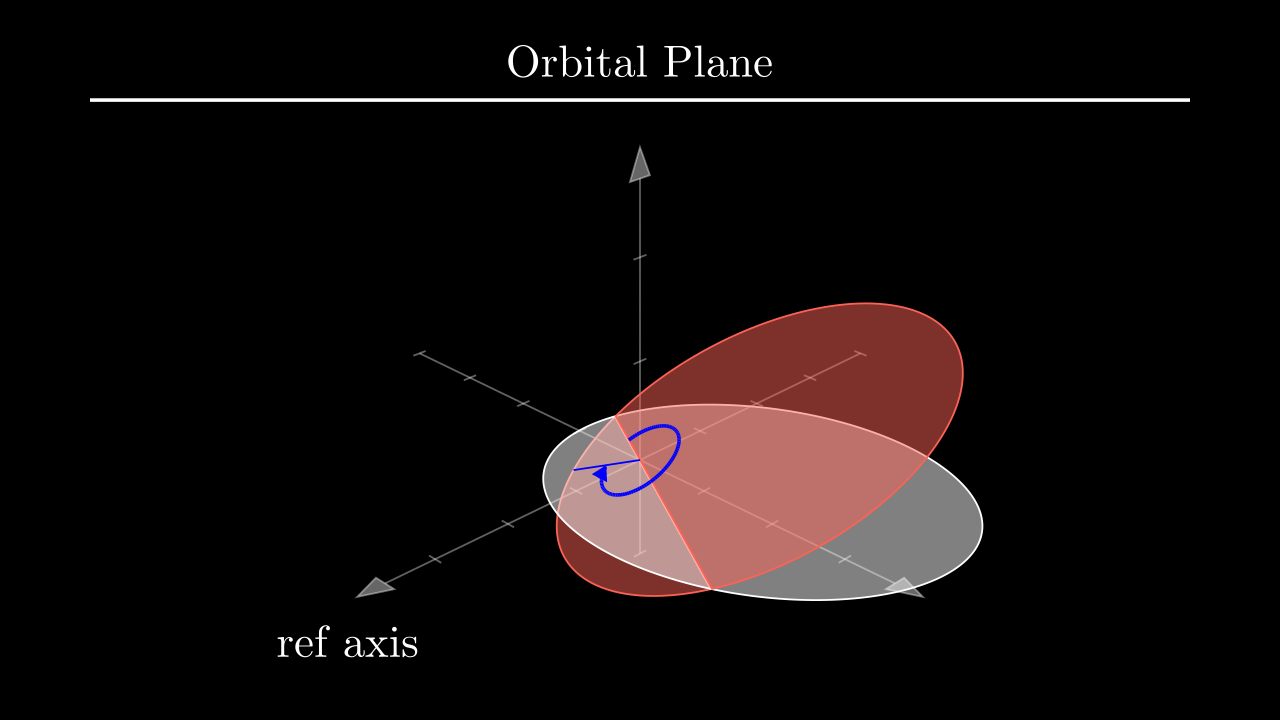

In [7]:
%%manim -qm --fps 60 $video_scene


class orbital_plane_Scene(ThreeDScene):
    def construct(self):
        # CVC = Text('CVC', font_size = 12, weight = BOLD, color = WHITE, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
        # self.add(CVC) 
        # self.set_camera_orientation(phi=75*DEGREES, theta=-45*DEGREES)

        # headline
        headline_orbital_plane = Title(r"Orbital Plane", font_size = 48).align_on_border(UP + LEFT, buff = 0.5).shift(0.5 * RIGHT) 
        self.add(headline_orbital_plane)


        # 3D-Coordinate System (a disgrace)
        CO3D = [0, 0, 0]
        CO3D_x_range = (-4, 4, 1)
        CO3D_y_range = (-4, 4, 1)
        CO3D_z_range = (-1, 3, 1)
        ax = ThreeDAxes(
            x_range = CO3D_x_range, y_range = CO3D_y_range, z_range = CO3D_z_range,
            x_length = 8, y_length = 8, z_length = 5, axis_config = {'tip_length': 0.05, 'tip_width': 0.3}, 
            z_axis_config = {'color': WHITE},
            ).move_to(CO3D).rotate(
                axis = [1, 0, 0], angle = 6*PI/4
                ).rotate(
                    axis = [0, 1, 0], angle = 5*PI/4
                    ).rotate(axis = [1, 0, 0], angle = PI/7).set_opacity(0.4)
        aries_label = Tex("ref axis").move_to([-3.25, -3.125, 0])
        self.add(ax, aries_label)


        # orbital plane parameters
        periabsis = 2
        periabsis_factor = 1.25

        # orbital plane rotations
        inclination = 0.5
        omega = 3*PI/4 + PI
        Omega = -PI/6

        # inclination = 0
        # omega = PI/2
        # Omega = 0

        # orbital plane
        orbital_plane = OrbitalPlane(ax, periabsis, periabsis_factor)
        reference_plane = orbital_plane.get_reference_plane(inclination, Omega, omega)
        orbital_plane_ellipsis = orbital_plane.get_orbital_plane(inclination, Omega, omega)
        orbital_plane_plus = orbital_plane_ellipsis[0]
        orbital_plane_minus = orbital_plane_ellipsis[1]
        orbital_plane_periapsis = orbital_plane.get_periapsis(inclination, Omega, omega)
        orbital_plane_omega_arc = orbital_plane.get_omega_label(inclination, Omega, omega)

        # planets
        image_sun = ImageMobject("../external_media/sun.png").scale(0.1).move_to(ax.c2p(0, 0, 0))
        exoplanet_position = orbital_plane.get_rotated_orbit_position(0, inclination, Omega, omega)
        image_exoplanet = ImageMobject("../external_media/exoplanet.png").scale(0.02).move_to(ax.c2p(*exoplanet_position))
        exoplanet_orbit = orbital_plane.get_orbit(inclination, Omega, omega)
        # self.add(exoplanet_orbit)
        # self.add(image_sun, image_exoplanet)


        def exoplanet_updater(planet):
            t = t_tracker.get_value()
            exoplanet_position = orbital_plane.get_rotated_orbit_position(t, inclination, Omega, omega)
            planet.move_to(ax.c2p(*exoplanet_position))


        # reference plane
        # reference_plane = Polygon(
        #     ax.c2p(4, 4, 0), 
        #     ax.c2p(4, -4, 0),
        #     ax.c2p(-4, -4, 0),
        #     ax.c2p(-4, 4, 0),
        #     color = WHITE, fill_opacity = 0.75, stroke_opacity = 1)

        # adding the objects in the "right" order because manim is retarded
        self.add(orbital_plane_minus)
        self.add(reference_plane)
        self.add(orbital_plane_plus)
        self.add(orbital_plane_periapsis)

        # labels
        self.add(orbital_plane_omega_arc)


        # self.wait(1.5)
        t_tracker = ValueTracker(0)
        # image_exoplanet.add_updater(exoplanet_updater)
        # self.play(t_tracker.animate.set_value(2*PI), rate_func = linear, run_time = 10)
        # self.wait(3)